<a href="https://colab.research.google.com/github/alexey9019/data/blob/master/sem_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Закрепление материала, разбор проблем, сверточные сети

План занятия:

* Разбор дз №2
* Возникающие проблемы
* Закрепление алгоритмов

## Разбор ДЗ №2:

https://colab.research.google.com/drive/1MXZEz00YAOEWlfuhN_O7Jd3b8S1qzGGV

# Проблемы и вопросы

## Балансировка нескольких классов

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [0]:
# создадим случайные синтетические данные из 3х классов - 0, 1, 2
data = np.random.randint(low=0, high=3, size=500)
# создадим Х и y из них
data = pd.DataFrame({'X':data, 'y':data})
# найдем их количество
print(data['y'].value_counts())

0    177
2    176
1    147
Name: y, dtype: int64


Что нам нужно найти?

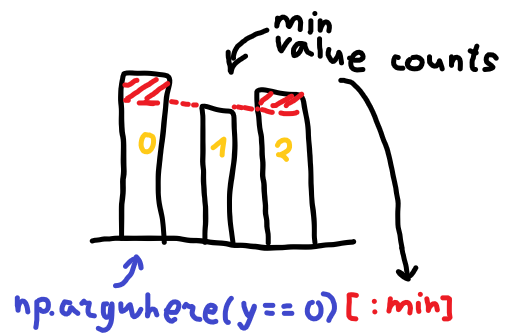

In [0]:
data.head(10)

,X,y
0,2,2
1,1,1
2,1,1
3,0,0
4,1,1
5,0,0
6,0,0
7,2,2
8,2,2
9,1,1


In [0]:
# тут мы нашли 0 и 2 строки нашего датафрейма
data.iloc[[0, 2]]
# осталось найти нужные индексы, количество которых для каждого класса будет одинаково и равно мин кол-ву в одном классе

,X,y
0,2,2
2,1,1


In [0]:
# На вход получаем столбец ответов (pd.Series)
def balance_many_classes(y):
    # находим минимальное кол-во элементов
    min_amm = y.value_counts().min()
    # находим целевые переменные столбца ответов
    classes_target_values = list(y.value_counts().index)
    # создаем массив, куда запишем все переменные
    ids = np.array([])
    # проходимся по всем уникальным значениям целевой переменной
    for target in classes_target_values:
        # находим их id
        selected_ids = np.argwhere(y==target).T[0]
        # перемешиваем
        np.random.shuffle(selected_ids)
        # обрезаем под нужный размер
        selected_ids = selected_ids[:min_amm]
        # добавляем в финальную выборку
        ids = np.append(ids, selected_ids)
    # перемешиваем
    np.random.shuffle(ids)
    # приводим в формат int, для того, чтоб успешно сконвертировалось
    ids = np.array(ids, int)
    return ids

In [0]:
# найдем все id, обрезанные под минимальный размер в y
balanced_ids = balance_many_classes(data['y'])
# используем как индексы
data = data.iloc[balanced_ids]
# находим кол-во уникальных - сбалансировали!
data['y'].value_counts()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


2    147
1    147
0    147
Name: y, dtype: int64

## Несколько roc-auc кривых

На основе [примера из оффициальной документации](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

In [0]:
from sklearn import datasets

# импортируем датасеты ириса
iris = datasets.load_iris()
# инициализируем обучающую выборку
X = iris.data
# инициализируем ответы
y = iris.target
# посмотрим на один пример
print(X[0], y[0])

[5.1 3.5 1.4 0.2] 0


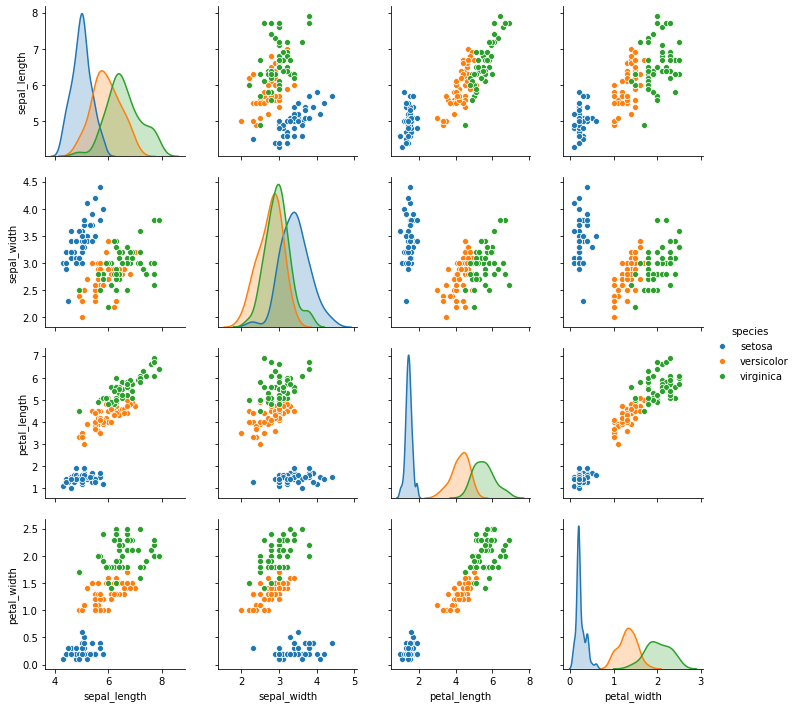

In [0]:
import matplotlib

# загрузим для визуализации
df_iris = sns.load_dataset("iris")

# изменим размер подписей
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
# построим попарный график
sns.pairplot(df_iris, hue="species")

In [0]:
from sklearn.preprocessing import label_binarize

# переводим в бинарный вид ответы
y = label_binarize(y, classes=[0, 1, 2])
print(y[:2])
# определяем количество классов
n_classes = y.shape[1]
print('Кол-во классов:',n_classes)

[[1 0 0]
 [1 0 0]]
Кол-во классов: 3


In [0]:
# добавляем случайный шум в данные для демонстрации
# устанавливаем ключ для генирации
random_state = np.random.RandomState(0)
# находим кол-во элементов и признаков
n_samples, n_features = X.shape
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.c_.html
# добавляем 200*кол-во признаков столбцов шума
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

In [0]:
len(X[0])

804

In [0]:
# исходные данные все еще на первых 4х позициях
print(X[0][:4])

[5.1 3.5 1.4 0.2]


In [0]:
from sklearn.model_selection import train_test_split

# перемешиваем и разделяем на train test с фиксированным random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

In [0]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (75, 804)
X_test: (75, 804)
y_train: (75, 3)
y_test: (75, 3)


In [0]:
y_train[0]

array([1, 0, 0])

In [0]:
# испортируем SMV и Один против всех
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

# Один против всех создает по классификатору на класс, для каждого из которых этот класс сопоставляется со всеми другими классами
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=random_state))

In [0]:
# обучаем и получаем ответы на тесте
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [0]:
# посмотрим на первое предсказание и первый ответ
y_score[0], y_test[0]

(array([-0.76301132, -0.36482547,  0.12386354]), array([0, 0, 1]))

In [0]:
from sklearn.metrics import roc_curve, auc

# находим рок кривую и площадь под ROC кривой для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
# проходимся по всем классам
for i in range(n_classes):
    # находим false positive rate и true positive rate для каждого класса
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    # находим площадь под рок кривой для кажого класса
    roc_auc[i] = auc(fpr[i], tpr[i])

In [0]:
roc_auc

{0: 0.9126984126984127, 1: 0.6037037037037037, 2: 0.7867647058823529}

In [0]:
fpr[0], tpr[0]

(array([0.        , 0.        , 0.        , 0.01851852, 0.01851852,
        0.03703704, 0.03703704, 0.05555556, 0.05555556, 0.07407407,
        0.07407407, 0.09259259, 0.09259259, 0.12962963, 0.12962963,
        0.14814815, 0.14814815, 0.2037037 , 0.2037037 , 0.27777778,
        0.27777778, 1.        ]),
 array([0.        , 0.04761905, 0.14285714, 0.14285714, 0.19047619,
        0.19047619, 0.33333333, 0.33333333, 0.38095238, 0.38095238,
        0.61904762, 0.61904762, 0.66666667, 0.66666667, 0.76190476,
        0.76190476, 0.9047619 , 0.9047619 , 0.95238095, 0.95238095,
        1.        , 1.        ]))

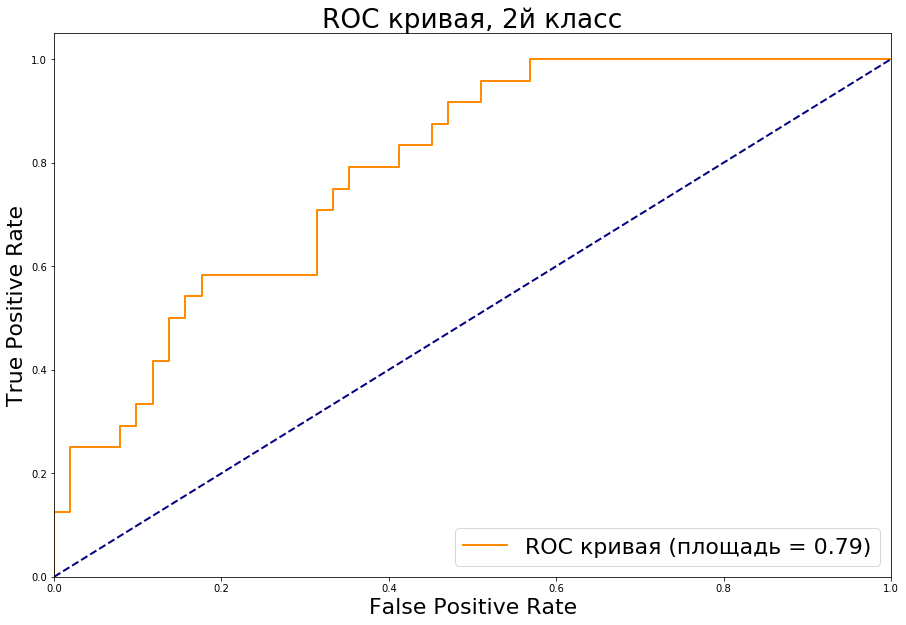

In [0]:
# меняем размер графика
fig = plt.figure(figsize=(15,10))
# устанавливаем читаемый размер шрифта
plt.rcParams.update({'font.size': 22})
# устанавливаем ширину линии на 2
lw = 2
# строим в координатах fpr и tpr кривую и смотрим на ее площадь
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC кривая (площадь = %0.2f)' % roc_auc[2])
# устанавливаем маштабы, в которых происходит отображение и создаем штрихованную линию = уровень случайного гадания
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# подписи координат
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# название графика
plt.title('ROC кривая, 2й класс')
# легенда графика и ее позиция
plt.legend(loc="lower right")
plt.show()

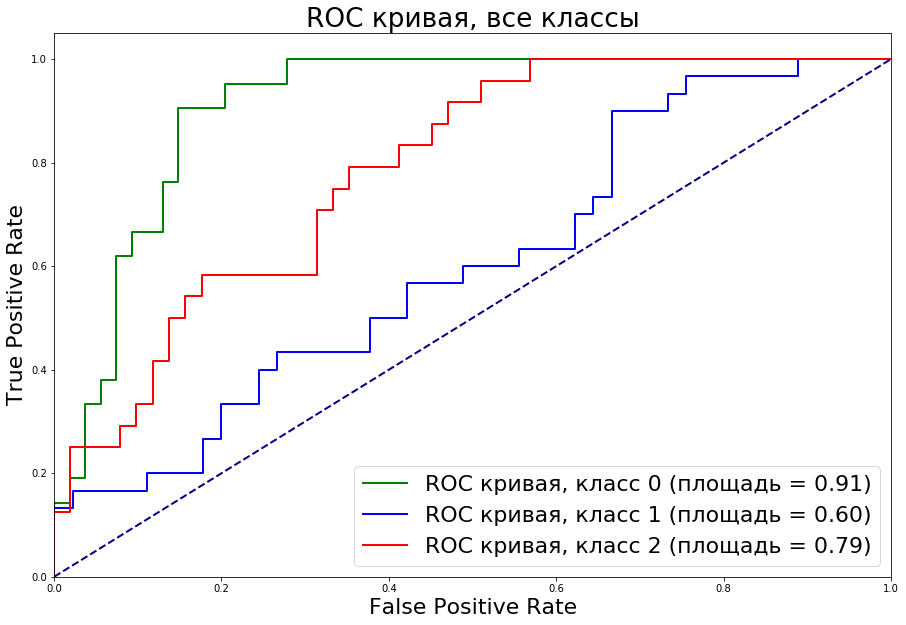

In [0]:
# меняем размер графика
fig = plt.figure(figsize=(15,10))
# устанавливаем читаемый размер шрифта
plt.rcParams.update({'font.size': 22})
# устанавливаем ширину линии на 2
lw = 2
# строим в координатах fpr и tpr кривую и смотрим на ее площадь
plt.plot(fpr[0], tpr[0], color='green', lw=lw, label='ROC кривая, класс 0 (площадь = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue', lw=lw, label='ROC кривая, класс 1 (площадь = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='red', lw=lw, label='ROC кривая, класс 2 (площадь = %0.2f)' % roc_auc[2])
# устанавливаем маштабы, в которых происходит отображение и создаем штрихованную линию = уровень случайного гадания
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# подписи координат
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# название графика
plt.title('ROC кривая, все классы')
# легенда графика и ее позиция
plt.legend(loc="lower right")
plt.show()

# Сверточные сети

## Загрузка данных

In [0]:
import warnings
# отключаем предупреждения
warnings.filterwarnings('ignore')

In [0]:
!git clone https://github.com/tixonsit/Sberbank_materials.git

Cloning into 'Sberbank_materials'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 41 (delta 3), reused 9 (delta 2), pack-reused 31
Unpacking objects: 100% (41/41), done.


In [0]:
!ls '/content/Sberbank_materials'

1.jpg			       sample_submission.csv	    test_toxic.csv
2.png			       sample_submission_digit.csv  text.txt
bank-additional-full.csv       telecom_churn.csv	    train.csv
bank.csv		       test.csv			    train_digit.csv
data.json		       test_digit.csv		    train_toxic.csv
online_shoppers_intention.csv  test_labels.csv		    Untitled.ipynb


In [0]:
# обучающая выборка
train = pd.read_csv("/content/Sberbank_materials/train_digit.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# тестовая выборка
test= pd.read_csv("/content/Sberbank_materials/test_digit.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# определяем целевую
Y_train = train["label"]
# дропаем ее из обучающей
X_train = train.drop(labels = ["label"], axis = 1) 

## Графический анализ

1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64

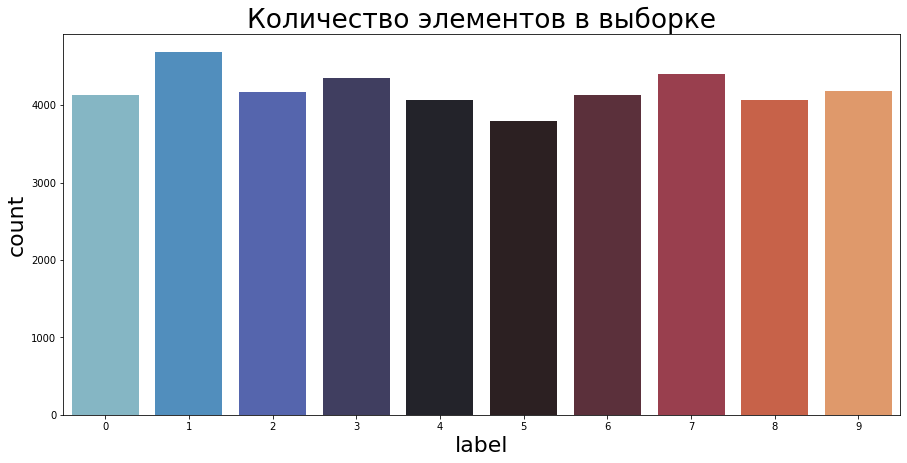

In [0]:
# визуализируем сбалансированность данных
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train, palette="icefire")
plt.title("Количество элементов в выборке")
Y_train.value_counts() / len(Y_train)

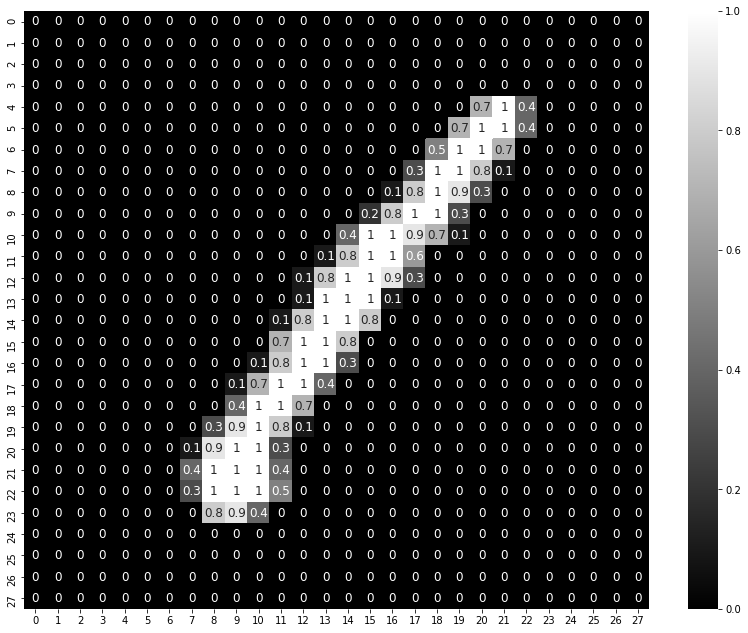

In [0]:
# установим размер графика
plt.figure(figsize=(14,11))
# поменяем размер шрифта для удобства отображения
plt.rcParams.update({'font.size': 12})
# отобразим первую картивнку (с выкинутым лейблом)
pixels01 = train.iloc[0][1:]
# разделим все 0..255 на 255
pixels01 /= 255
# отобразим на тепловой карте
sns.heatmap(np.round(pixels01.values.reshape((28,28)), 1), annot=True, cmap='gray');

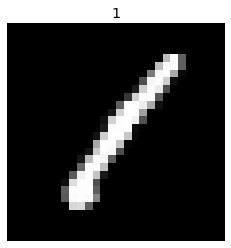

In [0]:
# Сокращенный вид
img = X_train.iloc[0].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
# название графика по ответам
plt.title(train.iloc[0,0])
# отключаем подсветку осей
plt.axis("off")
plt.show()

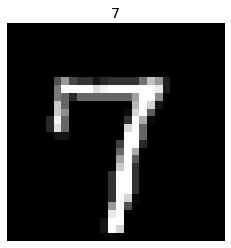

In [0]:
# 6й элемент, для разнообразия
img = X_train.iloc[6].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
# название графика по ответам
plt.title(train.iloc[6,0])
plt.axis("off")
plt.show()

# Работа с признаками

Проведем:
* Нормализацию
 * нормализация сделает числа меньше - вычисления будут происходить быстрее и точнее
 * будем нормалировать оттенками серого, чтобы уменьшить эффект различий освещения
* Переформатирование
 * в 28*28 <- работаем с двумерными данными на train и test
 * (для нужд библиотек укажем, что у нас один канал 28 * 28 * 1
* Кодирование данных
 * Проведем one hot кодирование

In [0]:
# Нормализация данных
X_train = X_train / 255.0
test = test / 255.0
print("X_train: ", X_train.shape)
print("test: ", test.shape)

X_train:  (42000, 784)
test:  (28000, 784)


In [0]:
# Нормализация данных, указание 1 канала
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print("X_train: ",X_train.shape)
print("test: ",test.shape)

X_train:  (42000, 28, 28, 1)
test:  (28000, 28, 28, 1)


In [0]:
# one hot кодирование
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(Y_train, num_classes = 10)

Using TensorFlow backend.


Train / test разделим в соотношении 90 на 10

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=0)

print("X_train", X_train.shape)
print("X_test", X_val.shape)
print("y_train", Y_train.shape)
print("y_test", Y_val.shape)

X_train (37800, 28, 28, 1)
X_test (4200, 28, 28, 1)
y_train (37800, 10)
y_test (4200, 10)


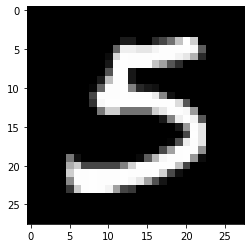

In [0]:
# Пример
plt.imshow(X_train[10][:,:,0],cmap='gray')
plt.show()

# Архитектура сверточной сети

![alt text](https://preview.ibb.co/nRkBpp/gec2.jpg)


Операция свертки:
* Ядро свертки = фильтр = детектор признаков
* Карта признаков = ядро свертки(изображение / другая карта)
* У нас есть некоторые изображения и ядро свертки (3*3)
 * Ядро свертки не обязательно быть матрицей 3 на 3. Это может быть 5 на 5 или 7 на 7.
 * Ядро свертки обнаруживает особенности изображение как края или выпуклые формы. 
* Stride = шаг по изображению, по умолчанию 1
* Padding, можно добавить по краям нули:

![alt text](https://preview.ibb.co/noH5Up/padding.jpg)

* Пример работы ядра свертки:

![alt text](https://image.ibb.co/m4FQC9/gec.jpg)

* Использование ReLU дает нам

![alt text](https://preview.ibb.co/gbcQvU/RELU.jpg)

* Max Pooling
 * Уменьшает вычислительную сложность
 * Нам не важен масштаб (инвариантность относително масштаба)

 ![alt text](https://preview.ibb.co/gsNYFU/maxpool.jpg)

* Flatten

![alt text](https://image.ibb.co/c7eVvU/flattenigng.jpg)

* Dropout

![alt text](https://preview.ibb.co/e7yPPp/dropout.jpg)

* Классические определения в нейросети

![alt text](https://preview.ibb.co/evzsAU/fullyc.jpg)

Создадим модель из 

conv => max pool => dropout => conv => max pool => dropout => fully connected (2 layer)

In [0]:
# импортируем нужные слои
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [0]:
# последовательная модель
model = Sequential()
# same - размер карты до и после одинаков
# двумерная свертка из 8 ядер свертки размера 5*5 и активацией relu
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
# макс пулинг по картинкам выше
model.add(MaxPool2D(pool_size=(2,2)))
# 25% вероятность не сработать
model.add(Dropout(0.25))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation = "softmax"))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

Вот как выглядит loss (categorical crossentropy)


![alt text](https://preview.ibb.co/nN3ZaU/cce.jpg)

In [0]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
epochs = 15
batch_size = 64

## Увеличение Объема Данных

* Чтобы избежать проблемы переобучения, нам нужно искусственно расширить наш рукописный цифровой набор данных
* Изменить обучающие данные с помощью небольших преобразований, чтобы воспроизвести изменения цифр
* Например, число не центрировано; масштаб не совпадает (некоторые большие / малые числа); изображение поворачивается

![alt text](https://preview.ibb.co/nMxXUp/augment.jpg)

In [0]:
# расширение выборки
datagen = ImageDataGenerator(
        featurewise_center=False,  # входное среднее значение в 0 для набора данных
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # разделить входные данные на стандартное отклонение набора данных
        samplewise_std_normalization=False,  # разделите каждый вход на его стандартное отклонение
        zca_whitening=False,  # уменьшение размерности
        rotation_range=0.5,  # произвольно поворачиваем изображения в диапазоне 5 градусов
        zoom_range = 0.5, # произвольно увеличиваем на 5%
        width_shift_range=0.5,  # произвольно сдвигаем по горизонтали на 5%
        height_shift_range=0.5,  # произвольно сдвигаем по вертикали на 5%
        horizontal_flip=False,  # произвольно переворачиваем по горизонтали
        vertical_flip=False)  # произвольно переворачиваем по вертикали

datagen.fit(X_train)

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(X_train,Y_train, batch_size=batch_size, callbacks = [earlyStopping, mcp_save],
                              epochs = epochs, validation_data = (X_val,Y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 37800 samples, validate on 4200 samples
Epoch 1/15





37800/37800 [==============================] - 26s 693us/step - loss: 0.8492 - acc: 0.7076 - val_loss: 0.1396 - val_acc: 0.9674
Epoch 2/15
37800/37800 [==============================] - 18s 471us/step - loss: 0.2635 - acc: 0.9356 - val_loss: 0.1105 - val_acc: 0.9733
Epoch 3/15
37800/37800 [==============================] - 18s 478us/step - loss: 0.1871 - acc: 0.9555 - val_loss: 0.0859 - val_acc: 0.9781
Epoch 4/15
37800/37800 [==============================] - 18s 476us/step - loss: 0.1555 - acc: 0.9631 - val_loss: 0.0705 - val_acc: 0.9831
Epoch 5/15
37800/37800 [==============================] - 18s 474us/step - loss: 0.1363 - acc: 0.9676 - val_loss: 0.0747 - val_acc: 0.9840
Epoch 6/15
37800/37800 [==============================] - 18s 475us/step - loss: 0.1288 - acc: 0.9707 - val_loss: 0.0729 - val_acc: 0.9845
Epoch 7/15
3780

## Оценка модели

* Визуализация test loss 
* Матрица ошибок

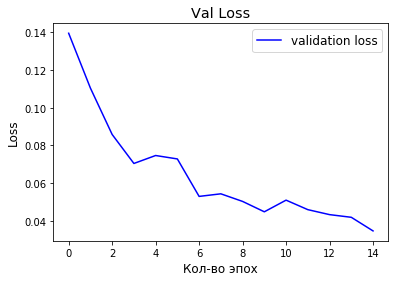

In [0]:
# Строим кривые потерь и точности для train и test
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Val Loss")
plt.xlabel("Кол-во эпох")
plt.ylabel("Loss")
plt.legend()
plt.show()

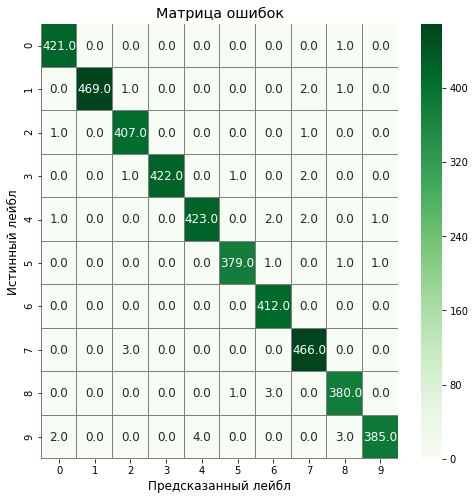

In [0]:
# матрица ошибок
from sklearn.metrics import confusion_matrix
# предсказываем на валидационном
Y_pred = model.predict(X_val)
# конвертируем предсказания в one hot
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# конвертируем валидационные проверочные в one hot
Y_true = np.argmax(Y_val,axis = 1) 
# считаем матрицу ошибок для всех
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# строим ее на графике
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Предсказанный лейбл")
plt.ylabel("Истинный лейбл")
plt.title("Матрица ошибок")
plt.show()

In [0]:
X_test.shape

(75, 804)

In [0]:
X_val.shape

(4200, 28, 28, 1)

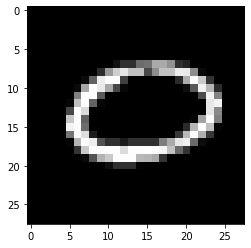

In [0]:
# Пример
plt.imshow(X_val[123][:,:,0],cmap='gray')
plt.show()

In [0]:
prediction = model.predict(np.array([X_val[123]]))[0]
prediction

array([9.9107623e-01, 1.3071790e-06, 1.4142895e-03, 6.3028965e-05,
       1.8909272e-04, 1.7445892e-04, 4.0454054e-03, 9.1900256e-05,
       3.6258815e-04, 2.5816597e-03], dtype=float32)

In [0]:
np.argmax(prediction)

0

<BarContainer object of 10 artists>

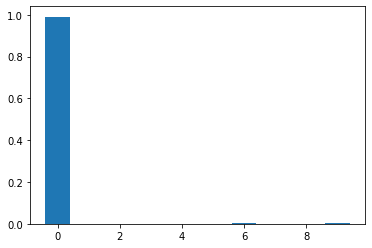

In [0]:
plt.bar([i for i in range(10)], prediction)